# Parsing CAM data (.json)

In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import random

number_of_colors = 20

color = []

while len(color) < 20:
    r = random.randint(0,255)
    g = random.randint(0,255)
    b = random.randint(0,255)
    rgb = [r,g,b]
    color.append(rgb)
    
print(color)

[[22, 208, 142], [34, 50, 236], [248, 119, 202], [246, 63, 27], [139, 95, 68], [58, 97, 3], [223, 128, 28], [135, 1, 118], [253, 108, 210], [142, 167, 212], [117, 34, 49], [186, 236, 211], [86, 251, 196], [121, 204, 93], [98, 107, 57], [156, 247, 170], [147, 175, 194], [202, 100, 230], [94, 89, 15], [10, 218, 77]]


In [2]:
color = [[44, 195, 74], [62, 208, 80], [53, 230, 195], [20, 216, 183], [235, 220, 95], [16, 138, 103], [170, 172, 255], [17, 150, 98], [252, 125, 2], [142, 155, 193], [117, 25, 29], [235, 119, 120], [105, 211, 222], [66, 52, 154], [1, 33, 128], [72, 182, 183], [183, 35, 106], [216, 217, 0], [204, 201, 74], [39, 41, 236]]

In [1]:
import json 
import numpy as np
import cv2
from matplotlib import pyplot as plt

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import os

import urllib.request as urllib2

In [4]:
PATH = './data/'
SAVE_PATH = './result_original_iou_VGG/'

In [5]:
#PATH = './sampleImg/'
#SAVE_PATH = './result_original_iou_Resnet/'

In [6]:
SAVE_DIR = 'person_dog_2/'

In [7]:
if not os.path.exists(SAVE_PATH+SAVE_DIR):
    os.makedirs(SAVE_PATH+SAVE_DIR)

In [8]:
with open(PATH+"persondog_2.json") as json_file:
    json_data = json.load(json_file)

cam_class = ["person", "dog"]

In [9]:
data_list = []

for cls in cam_class:
    data_list.append(np.array(json_data[cls], dtype='uint8'))

# heatmap 동작 확인

In [10]:
#IMG_URL = "https://image.chosun.com/sitedata/image/201809/10/2018091002391_0.jpg"

In [11]:
IMG_URL = "https://www.thesprucepets.com/thmb/N3hbYHfg7fmKylt00jxjgEOiwWE=/400x300/filters:no_upscale():max_bytes(150000):strip_icc()/running-with-dog-Westend61-getty-525469393-56a26b433df78cf772756764.jpg"

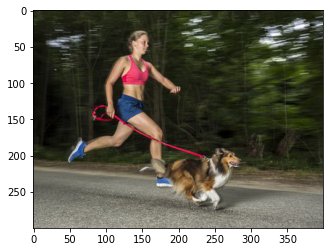

In [12]:
PIL_img = Image.open(urllib2.urlopen(IMG_URL))

img = cv2.cvtColor(np.array(PIL_img), cv2.COLOR_RGB2BGR)

dpi = 80
    
height, width, depth = img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

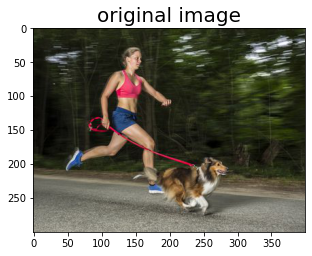

In [13]:
figsize = width / float(dpi) , height / float(dpi)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
_result_img = img.copy()
ax.imshow(cv2.cvtColor(_result_img, cv2.COLOR_BGR2RGB))
title = 'original image'
ax.set_title(title, fontsize=20)
plt.savefig(SAVE_PATH+SAVE_DIR+'original_image.png', bbox_inches='tight')
plt.show()

In [14]:
orig_heatmaps = []

height, width, _ = img.shape

for index, cls in enumerate(cam_class):+
    orig_heatmaps.append(cv2.applyColorMap(cv2.resize(data_list[index], (width, height)), cv2.COLORMAP_JET))

# color channel별 heatmap 뽑기

In [15]:
# orig_img에서 (R, G, B) 세 가지 채널의 정보 중 특정 채널의 정보만 남겨서 넘김
def get_channel_image(orig_img, channel):
    channel = channel.upper()
    channel_img = orig_img.copy()
    if channel == 'R':
        channel_img[:, :, 0] = 0
        channel_img[:, :, 1] = 0
    elif channel == 'G':
        channel_img[:, :, 0] = 0
        channel_img[:, :, 2] = 0
    elif channel == 'B':
        channel_img[:, :, 1] = 0
        channel_img[:, :, 2] = 0

    return channel_img

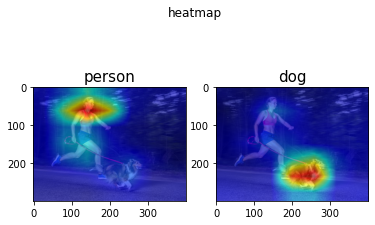

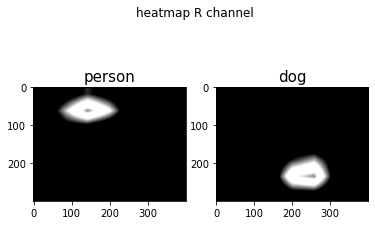

In [16]:
heatmaps = []

fig, ax = plt.subplots(nrows=1, ncols=len(orig_heatmaps))
fig.suptitle('heatmap')
for index, orig_heatmap in enumerate(orig_heatmaps):
    result = orig_heatmap*0.6 + img*0.4
    ax[index].set_title(cam_class[index], fontsize=15)
    ax[index].imshow(cv2.cvtColor(np.float32(result).astype('uint8'), cv2.COLOR_BGR2RGB))
    # orig_heatmap에서 `R` 계열이 가장 중요한 feature 부분을 나타내므로 해당 정보만 사용
    heatmaps.append(get_channel_image(orig_heatmap, 'r'))
    
plt.savefig(SAVE_PATH+SAVE_DIR+'heatmap.png', bbox_inches='tight')
plt.show()
    
fig, ax = plt.subplots(nrows=1, ncols=len(heatmaps))
fig.suptitle('heatmap R channel')
for index, heatmap in enumerate(heatmaps):
    # orig_heatmap의 R 채널 데이터를 gray scale로 출력
    ax[index].set_title(cam_class[index], fontsize=15)
    ax[index].imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY), cmap='gray')

plt.savefig(SAVE_PATH+SAVE_DIR+'heatmap_R_channel_grayscale.png', bbox_inches='tight')
plt.show()

# CAM 결과를 이용하여 Bounding Box 잡기

In [17]:
# color image를 gray scale로 바꾼 후, threshold를 적용함
# threshold는 고정 값으로 mean(min, max)
def get_grayscale_image_with_threshold(orig_img):
    gray_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    
    min_val = np.min(gray_img)
    max_val = np.max(gray_img)
    threshold = (min_val + max_val) / 2
    
    ret, gray_img = cv2.threshold(gray_img, threshold, 1, cv2.THRESH_BINARY)    

    return gray_img

In [18]:
# grayscale_mask 에서 1인 부분만 orig_img를 보여줌. 0인 부분은 검정색으로 보임
def get_masked_image(orig_img, gray_map):
    mask = cv2.cvtColor(gray_map, cv2.COLOR_GRAY2BGR)
    
    maskedRegion = np.where(mask == 1, orig_img, 0)
    
    return cv2.cvtColor(maskedRegion, cv2.COLOR_BGR2RGB)

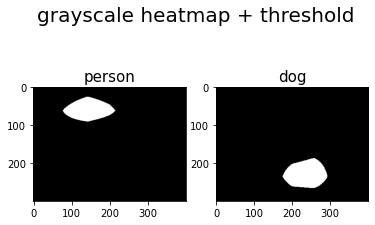

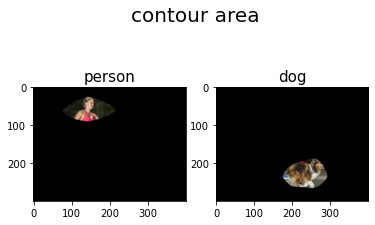

In [19]:
graymaps = []

for index, heatmap in enumerate(heatmaps):
    # gray scale img로 바꾸고, threshold 이상의 값만 binary로 살림
    graymaps.append(get_grayscale_image_with_threshold(heatmap))

# threshold가 적용된 graymap 결과 확인
fig, ax = plt.subplots(nrows=1, ncols=len(graymaps))
fig.suptitle('grayscale heatmap + threshold', fontsize=20)
for index, graymap in enumerate(graymaps):
    ax[index].set_title(cam_class[index], fontsize=15)
    ax[index].imshow(graymap, cmap="gray")
    
plt.savefig(SAVE_PATH+SAVE_DIR+'heatmap_grayscale_threshold.png', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=len(graymaps))
fig.suptitle('contour area', fontsize=20)
for index, graymap in enumerate(graymaps):
    ax[index].set_title(cam_class[index], fontsize=15)
    ax[index].imshow(get_masked_image(img, graymap))
plt.savefig(SAVE_PATH+SAVE_DIR+'heatmap_grayscale_threshold_mask.png', bbox_inches='tight')
plt.show()

In [20]:
def get_contours(img_binary):
    contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

In [21]:
def get_bounding_box(img_binary):
    bb = []
    
    contours = get_contours(img_binary)
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        bb.append([x, y, w, h])
        
    return bb

In [22]:
def draw_bounding_box(bounding_box, img):
    tmp_img = img.copy()

    dim = np.array(bounding_box).ndim
    
    if dim == 2:
        for x, y, w, h in bounding_box:
            cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    elif dim == 3:
        for bb in bounding_box:
            for x, y, w, h in bb:
                cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    return cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

In [23]:
def get_image_of_compare_contour_and_bounding_box(img_binary, img):
    
    contours = get_contours(img_binary)
    
    tmp_img = img.copy()
    
    # draw contours - red
    for cnt in contours:
        cv2.drawContours(tmp_img, [cnt], 0, (0,0,255),3)
    
    # draw bounding box - green
    bb = get_bounding_box(img_binary)
    for x, y, w, h in bb:
        cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
        
    return cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)

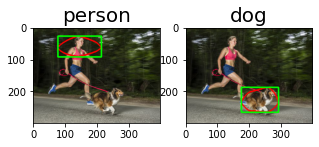

In [24]:
figsize = width / float(dpi) , height / float(dpi) * 2
fig, ax = plt.subplots(nrows=1, ncols=len(heatmaps), figsize=figsize)

for index, graymap in enumerate(graymaps):
    # contour 영역과 bounding box 비교
    ax[index].set_title(cam_class[index], fontsize=20)
    ax[index].imshow(get_image_of_compare_contour_and_bounding_box(graymap, img))
    
plt.savefig(SAVE_PATH+SAVE_DIR+'CAM_contour.png', bbox_inches='tight')
plt.show()

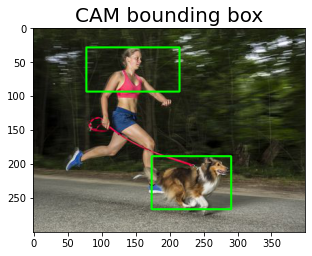

In [25]:
CAM_BB = []

for index, graymap in enumerate(graymaps):
    CAM_BB.append(get_bounding_box(graymap))



figsize = width / float(dpi) , height / float(dpi)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.imshow(_result_img)
title = 'CAM bounding box'
ax.set_title(title, fontsize=20)
plt.savefig(SAVE_PATH+SAVE_DIR+'CAM_bbox.png', bbox_inches='tight')
plt.show()

# Selective Search 결과와 CAM Bounding Box 비교

In [26]:
def cv2_selective_search(img, searchMethod='f'):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    
    if searchMethod == 'f':
        ss.switchToSelectiveSearchFast()
    elif searchMethod == 'q':
        ss.switchToSelectiveSearchQuality()
        
    regions = ss.process()
    
    return regions

num of all regions by ss: 983


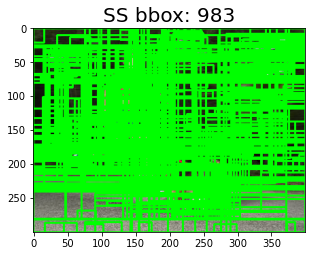

In [27]:
SS_BB = cv2_selective_search(img)

print(f'num of all regions by ss: {len(SS_BB)}')
_result_img = draw_bounding_box(SS_BB, img)


figsize = width / float(dpi) , height / float(dpi)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.imshow(_result_img)
title = f'SS bbox: {len(SS_BB)}'
ax.set_title(title, fontsize=20)
plt.savefig(SAVE_PATH+SAVE_DIR+'SS_bbox.png', bbox_inches='tight')
plt.show()

In [28]:
def get_iou(_bb1, _bb2, changeScale = False, basedOnCAM = False):
    # _bb2 == cam_bb
    if changeScale:
        # _bb1, _bb2 = [x, y, w, h]
        if len(_bb1) == 4 and len(_bb2) == 4:
            bb1 = {'x1':_bb1[0], 'y1':_bb1[1], 'x2':_bb1[0]+_bb1[2], 'y2':_bb1[1]+_bb1[3]}
            bb2 = {'x1':_bb2[0], 'y1':_bb2[1], 'x2':_bb2[0]+_bb2[2], 'y2':_bb2[1]+_bb2[3]}
        else:
            exit(0)
    else:
        # _bb1, _bb2 = ['x1':x1, 'x2':x2, 'y1':y1, 'y2':y2]
        x1, y1, x2, y2 = _bb1
        bb1 = {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
        x1, y1, x2, y2 = _bb2
        bb2 = {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
    
    
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    
    if basedOnCAM:
        # cam_bb 기준 iou
        iou = intersection_area / float(bb2_area)
    else:
        iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [29]:
def isExist(bounding_box, bb):
    for _bb in bounding_box:
        if np.array_equal(_bb, bb):
            return True
    return False

In [30]:
def get_candidate_bounding_box(SS_BB, CAM_BB):
    # SS_BB dim = 2
    # CAM_BB dim = 3
    
    bounding_box = []

    for ss_bb in SS_BB:
        for cam_bbs in CAM_BB:
            for cam_bb in cam_bbs:
                iou = get_iou(ss_bb, cam_bb, changeScale = True, basedOnCAM=True)
                if iou > 0.7:
                    if not isExist(bounding_box, ss_bb):
                        bounding_box.append(ss_bb)
    return bounding_box

In [31]:
bounding_box = get_candidate_bounding_box(SS_BB, CAM_BB)

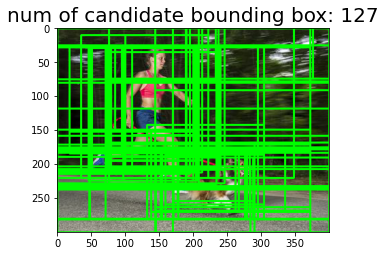

In [32]:
_result_img = draw_bounding_box(bounding_box, img)

figsize = width / float(dpi) , height / float(dpi)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.imshow(_result_img)
title = f'num of candidate bounding box: {len(bounding_box)}'
ax.set_title(title, fontsize=20)
plt.savefig(SAVE_PATH+SAVE_DIR+'candidate_bbox.png', bbox_inches='tight')
plt.show()

In [33]:
import json 
import numpy as np
import cv2
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time
import os
import copy
import sys

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import urllib.request as urllib2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [35]:
classes = ('aeroplane','bicycle','diningtable',
           'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor',
           'bird','boat','bottle','bus','car','cat','chair','cow')

In [36]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# vgg16

In [38]:
model = models.vgg16(pretrained=False)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=len(classes))
model = model.to(device)
model.load_state_dict(torch.load('../PASCAL VOC 2012 R-CNN/TrainedModel/PretrainedTrue'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Resnet

In [39]:
"""
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

model = model.to(device)
model.load_state_dict(torch.load('../PASCAL VOC 2012 R-CNN/TrainedModel/ResNet_pretrained_True'))
model.eval()
"""

"\nmodel = models.resnet50(pretrained=True)\nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, 20)\n\nmodel = model.to(device)\nmodel.load_state_dict(torch.load('../PASCAL VOC 2012 R-CNN/TrainedModel/ResNet_pretrained_True'))\nmodel.eval()\n"

In [40]:
def get_predict_result(probs):
    predict_score, predict_class = torch.max(probs, 1)
    return predict_score, predict_class

In [41]:
def get_predict(model, img):
    model.eval()
    
    with torch.no_grad():
        inputs = img.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs)
        softmax = nn.Softmax(dim=1)
        outputs = softmax(outputs)
        #print(outputs)
        return outputs
        #predict_score, predict_class = torch.max(outputs, 1)
        #print(predict_score)
        #print(predict_class)
        #return(predict_score, predict_class)

In [42]:
det_probs = []

for index, (x, y, w, h) in enumerate(bounding_box):
    area = (x, y, x + w, y + h)
    timage = PIL_img.crop(area)
    timage = data_transforms['test'](transforms.ToPILImage()(np.asarray(timage)))
    prob = get_predict(model, timage)
    det_probs.append(prob.tolist()[0])
    
det_probs = torch.as_tensor(det_probs)
print(det_probs.shape)
print(det_probs)

torch.Size([127, 20])
tensor([[1.8753e-19, 5.8729e-17, 4.2977e-19,  ..., 4.2159e-17, 5.5609e-14,
         1.1654e-15],
        [2.5809e-06, 2.7292e-05, 1.1139e-07,  ..., 1.1736e-06, 4.2768e-06,
         2.5231e-07],
        [1.1251e-06, 3.9937e-06, 3.6591e-07,  ..., 1.2245e-02, 1.7470e-06,
         5.3418e-05],
        ...,
        [3.8818e-04, 4.8937e-03, 4.7754e-04,  ..., 1.2895e-02, 4.0947e-03,
         2.5550e-03],
        [1.9137e-09, 6.5815e-08, 1.7731e-10,  ..., 9.1976e-10, 4.2956e-07,
         4.6382e-09],
        [2.0828e-19, 3.5549e-16, 1.4782e-18,  ..., 3.2320e-19, 9.4185e-11,
         2.2840e-17]])


In [43]:
def draw_result(bounding_box, probs):
    
    draw = 0
    _opencvImg = img.copy()
    
    figsize = width / float(dpi) , height / float(dpi)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
        
    for cnt in range(len(bounding_box)):
        
        cls_idx = torch.argsort(probs[cnt, :], descending=True)[0]
        
        if probs[cnt][cls_idx] > 0:
            print(f'class {classes[cls_idx]}: {probs[cnt][cls_idx]}')
            draw += 1
            x,y,w,h = bounding_box[cnt]
            _opencvImg = cv2.rectangle(_opencvImg, (x, y,), (x+w, y+h), color[cls_idx], 2)
            text = '{} ({:.3f})'.format(classes[cls_idx], probs[cnt][cls_idx])
            cv2.putText(_opencvImg, text, (x, y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color[cls_idx], 1) 
            
            
    ax.imshow(cv2.cvtColor(_opencvImg, cv2.COLOR_BGR2RGB))
    title = f'final bbox: {draw}'
    ax.set_title(title, fontsize=20)
    plt.savefig(SAVE_PATH+SAVE_DIR+'result.png', bbox_inches='tight')
    plt.show()
    
    print(f'final bbox: {draw}')
    
    return

In [44]:
def draw_result_by_class(bounding_box, probs):
    
    _opencvImg = img.copy()
    dpi = 80
    
    height, width, depth = _opencvImg.shape
    
    figsize = width / float(dpi) * 5, height / float(dpi) * 4
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=figsize)
    
    for i in range(20):
        row = int(i / 5)
        col = i % 5
        
        _opencvImg = img.copy()
        
        draw = 0
        
        for cnt in range(len(bounding_box)):
            
            cls_idx = torch.argsort(probs[cnt, :], descending=True)[0]
            if cls_idx == i:
                if probs[cnt][cls_idx] > 0:
                    draw += 1
                    x,y,w,h = bounding_box[cnt]
                    _opencvImg = cv2.rectangle(_opencvImg, (x, y,), (x+w, y+h), color[cls_idx], 3)
                    text = '{} ({:.3f})'.format(classes[cls_idx], probs[cnt][cls_idx])
                    cv2.putText(_opencvImg, text, (x, y+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color[cls_idx], 2)
        
        title = classes[i] + ": "+str(draw)
        ax[row][col].set_title(title, fontsize=20)
        ax[row][col].imshow(cv2.cvtColor(_opencvImg, cv2.COLOR_BGR2RGB))

    
    plt.savefig(SAVE_PATH+SAVE_DIR+'result_by_class.png', bbox_inches='tight')

In [45]:
def nms(bounding_box, probs):
    
    bbox = []

    for x, y, w, h in bounding_box:
        bbox.append([x,y, x+w, y+h])
    
    
    _opencvImg = img.copy()
    bbox = torch.as_tensor(bbox).float()
    probs = torch.as_tensor(probs)
    for c in range(len(classes)):
        
        _cnt = 0
        
        # threshold 적용
        
        prob = probs[:, c].clone()
        
        m = nn.Threshold(0.2, 0)
        
        prob = m(prob)
        
        order = torch.argsort(prob, descending=True)
        
        #print(prob)
        #print(order)
        
        for i in range(len(order)):
            printProgressBar (i, len(order), prefix = f'class {c}', suffix = 'complete', length = 50)
            bbox_max = bbox[order[i]]
            for j in range(i+1, len(order)):
                bbox_cur = bbox[order[j]]
                
                if get_iou(bbox_max, bbox_cur) > 0.5:
                    prob[order[j]] = 0
        
        printProgressBar (len(order), len(order), prefix = f'class {c}', suffix = 'complete', length = 50)
        probs[:, c] = prob
        
    return probs
    return 

class 0 |██████████████████████████████████████████████████| 100.0% complete
class 1 |██████████████████████████████████████████████████| 100.0% complete
class 2 |██████████████████████████████████████████████████| 100.0% complete
class 3 |██████████████████████████████████████████████████| 100.0% complete
class 4 |██████████████████████████████████████████████████| 100.0% complete
class 5 |██████████████████████████████████████████████████| 100.0% complete
class 6 |██████████████████████████████████████████████████| 100.0% complete
class 7 |██████████████████████████████████████████████████| 100.0% complete
class 8 |██████████████████████████████████████████████████| 100.0% complete
class 9 |██████████████████████████████████████████████████| 100.0% complete
class 10 |██████████████████████████████████████████████████| 100.0% complete
class 11 |██████████████████████████████████████████████████| 100.0% complete
class 12 |██████████████████████████████████████████████████| 100.0% compl

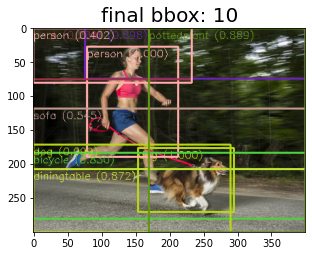

final bbox: 10


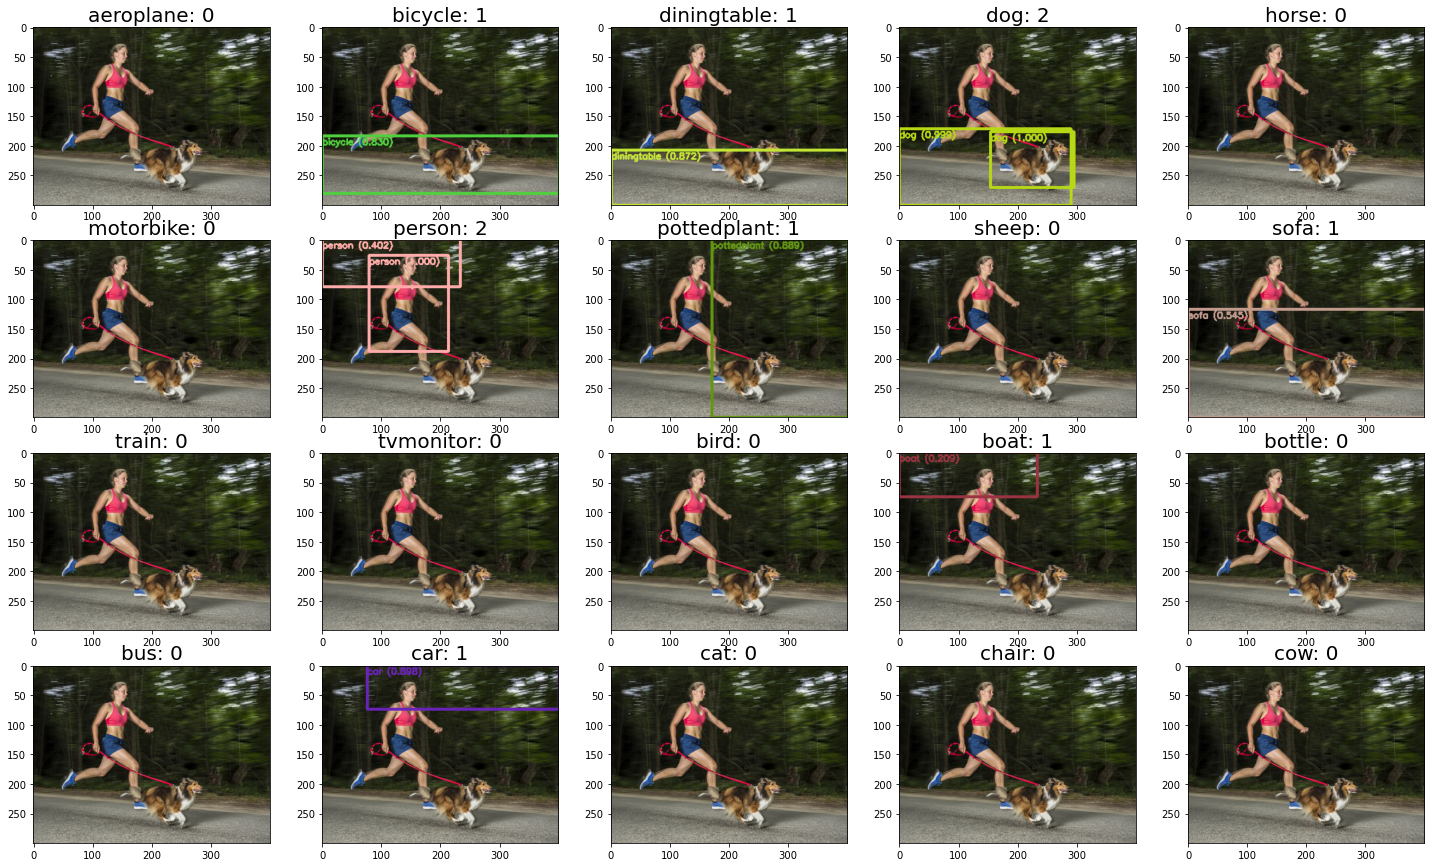

In [46]:
final_probs = nms(bounding_box, det_probs)
draw_result(bounding_box, final_probs)
draw_result_by_class(bounding_box, final_probs)